<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Install-FastAI-Library" data-toc-modified-id="Install-FastAI-Library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Install FastAI Library</a></span></li><li><span><a href="#Collect-Data-from-Azure-Search-Image-Bing" data-toc-modified-id="Collect-Data-from-Azure-Search-Image-Bing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Collect Data from Azure Search Image Bing</a></span></li><li><span><a href="#Build-the-Classifier" data-toc-modified-id="Build-the-Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the Classifier</a></span><ul class="toc-item"><li><span><a href="#Evaluate-Model's-accuracy" data-toc-modified-id="Evaluate-Model's-accuracy-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Evaluate Model's accuracy</a></span></li></ul></li><li><span><a href="#Clean-the-data-using-classifier" data-toc-modified-id="Clean-the-data-using-classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clean the data using classifier</a></span></li><li><span><a href="#Turning-Your-Model-into-an-Online-Application" data-toc-modified-id="Turning-Your-Model-into-an-Online-Application-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Turning Your Model into an Online Application</a></span><ul class="toc-item"><li><span><a href="#Using-the-Model-for-Inference¶" data-toc-modified-id="Using-the-Model-for-Inference¶-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Using the Model for Inference¶</a></span></li></ul></li><li><span><a href="#Create-app-from-classifier" data-toc-modified-id="Create-app-from-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create app from classifier</a></span></li><li><span><a href="#Turn-Notebook-into-Real-App" data-toc-modified-id="Turn-Notebook-into-Real-App-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Turn Notebook into Real App</a></span></li></ul></div>

## Install FastAI Library

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *

## Collect Data from Azure Search Image Bing

In [4]:
#Key for Search Image Bing - to grab images from Bing (Microsoft Azure Service, Marketplace, Search Bing v7)
#key = '5ada79bd312c42ab88ef7a935c960e61'

In [2]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [ ]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [4]:
#path = Path('bears')
fns = get_image_files(path)
fns

(#305) [Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000039.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000013.jpg'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000006.jpg')...]

In [5]:
failed = verify_images(fns)
failed

failed.map(Path.unlink);

## Build the Classifier

In [6]:
# DataBlock
bears = DataBlock(
blocks = (ImageBlock, CategoryBlock),
get_items = get_image_files,
splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
get_y = parent_label,
item_tfms = Resize(128))

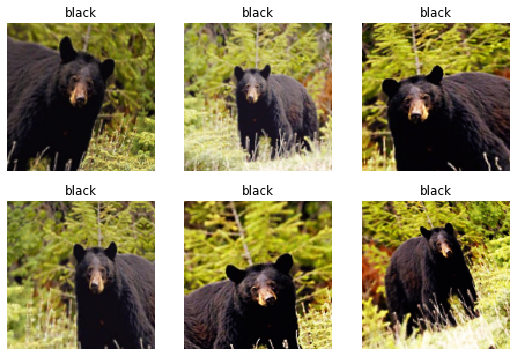

In [7]:
# Data Augmentation
#bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
#bears.new(item_tfms = Resize(128, method='squish'))
#bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
bears.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path, num_workers = 0, bs = 16)
dls.train.show_batch(max_n = 6, nrows = 2, unique = True)

In [8]:
!pwd

/Users/odomanska/Documents/Work/learning/FastAI


In [9]:
!ls -la

total 25200
drwxr-xr-x   8 odomanska  1819984877       256 Nov 23 15:34 .
drwxr-xr-x  16 odomanska  1819984877       512 Nov 18 13:53 ..
-rw-r--r--@  1 odomanska  1819984877      6148 Nov 23 15:21 .DS_Store
drwxr-xr-x   4 odomanska  1819984877       128 Nov 23 13:20 .ipynb_checkpoints
-rw-r--r--@  1 odomanska  1819984877      3842 Nov 23 13:10 BearClassifierApp.ipynb
-rw-r--r--@  1 odomanska  1819984877    832412 Nov 23 15:34 Widgets.ipynb
drwxr-xr-x   6 odomanska  1819984877       192 Nov 23 15:18 bears
-rw-r--r--@  1 odomanska  1819984877  11008633 Nov 23 15:24 export.pkl


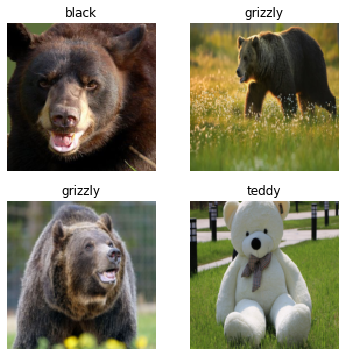

In [10]:
dls.valid.show_batch(max_n = 4, nrows = 2)

In [11]:
learn = cnn_learner(dls, alexnet, metrics = accuracy)

In [12]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.399187,0.187040,0.983607,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.345810,0.150225,0.983607,00:22
1,0.310968,0.127973,0.967213,00:23


### Evaluate Model's accuracy

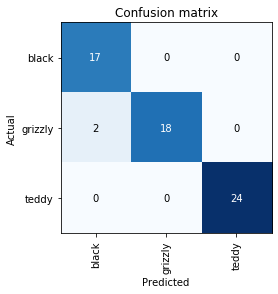

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

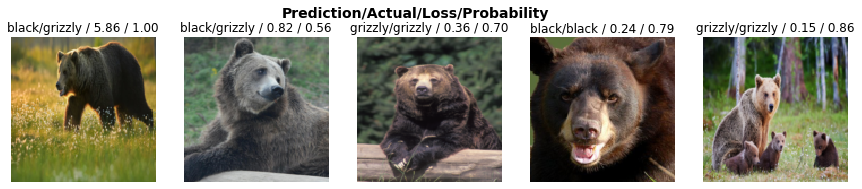

In [14]:
interp.plot_top_losses(5, nrows=1)

## Clean the data using classifier

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference¶

In [17]:
learn.export()

In [18]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [19]:
learn_inf = load_learner(path/'export.pkl')

In [20]:
#learn_inf.predict('btn_upload.data[0]')
#learn_inf.predict('io.BitesIO(btn_upload.data[0])')
learn_inf.predict('bears/teddy/00000000.jpg')

('teddy', TensorImage(2), TensorImage([1.5485e-06, 1.0814e-06, 1.0000e+00]))

In [21]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Create app from classifier

In [22]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
out_pl.clear_output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description = 'Classify')

In [23]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(256,256))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [24]:
VBox([widgets.Label('Select your Bear'), btn_upload, btn_run, out_pl, lbl_pred])

## Turn Notebook into Real App

In [ ]:
#mybinder.org + GitHub